In [387]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [388]:
%matplotlib inline
import seaborn as sns; sns.set()  # for plot styling
import itertools
import random

from typing import Dict, Optional, Union, List
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
import math
import random
import cv2
from IPython.display import Image

import pennylane as qml
from pennylane import numpy as np


np.warnings.filterwarnings('ignore')

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255   0   0 ... 255 255 255]
 ...
 [255   0   0 ... 255 255 255]
 [255   0   0 ... 255 255 255]
 [255   0   0 ... 255 255 255]]
(32, 32)


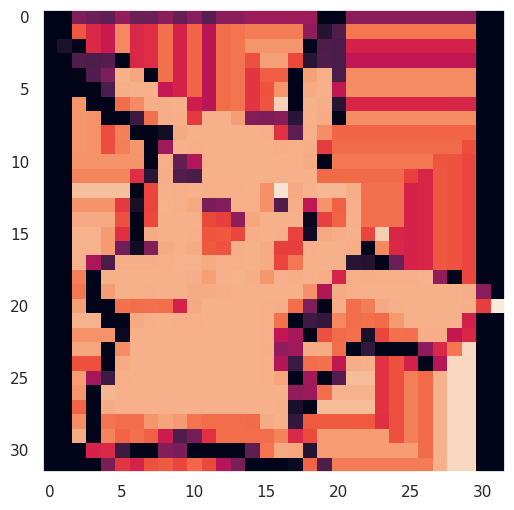

In [389]:
img = cv2.imread('pikachu.png', cv2.IMREAD_GRAYSCALE)
print(img)
img_size=32
img_size_qubits=math.ceil(math.log2(img_size))
img= cv2.resize(img,(32, 32))
print(img.shape)
plt.figure(figsize=(6, 6))
plt.grid(False)
plt.imshow(img)

In [390]:
pixel_values = img.reshape((-1, 1))
print(pixel_values.shape)
pixel_values = np.float32(pixel_values)
print(pixel_values)
print(len(pixel_values))

(1024, 1)
[[  0.]
 [  0.]
 [ 83.]
 ...
 [242.]
 [  0.]
 [  0.]]
1024


In [391]:
def where_to_apply_x(bin_number_length: int) -> List:
    indices=[]
    powers_of_two = 2 ** np.arange(bin_number_length)
    for pos in range(2**bin_number_length):
        temp=[]
        for ind, v in enumerate(powers_of_two):
            if v & (pos ^ (pos - 1)) == v:
                temp.append(ind)
        indices.append(temp)
    return indices

In [392]:
def layer(param, control_wires, target_wires):
    param=param/255*np.pi
    qml.MultiControlledX(control_wires, target_wires)
    qml.RY(-1*param/2, target_wires)
    qml.MultiControlledX(control_wires, target_wires)
    qml.RY(param/2, target_wires)

In [393]:
num_qubits = math.ceil(math.log2(len(pixel_values)))
print(num_qubits)
comp_basis_states = list(itertools.product(['0', '1'], repeat=num_qubits))

10


In [394]:
dev_dist_calc = qml.device("lightning.qubit", wires=num_qubits+1, shots=100000)

In [395]:
def image_encoding(data):    
    ctrl_wires_training=[i for i in range(1,1+math.ceil(math.log2(len(data))))]
    train_bin_number_length = len(ctrl_wires_training)
    where_x_train = where_to_apply_x(train_bin_number_length)

    for i in range(1,1+math.ceil(math.log2(len(data)))):
        qml.Hadamard(wires=i)
    for i in range(2**train_bin_number_length):
        for j in where_x_train[i]:
            qml.PauliX(1+train_bin_number_length-1-j)
        if i<len(data):
            layer(data[i][0], ctrl_wires_training, [0])
            #layer(data[i][1], ctrl_wires_training, [1])
            #layer(data[i][2], ctrl_wires_training, [2])


In [396]:
def RoR(start, end):
    print(end)
    for i in range(start,end):
        qml.SWAP(wires=[i, i+1])
        print(i)

In [397]:
def RoL(start, end):
    for i in range(end, start, -1):
        qml.SWAP(wires=[i, i-1])

In [398]:
def par_opt():
    qml.Hadamard(1)
    RoR(1,1+img_size_qubits-1)
    print("--------")
    qml.Hadamard(1+img_size_qubits)
    RoR(1+img_size_qubits,1+2*img_size_qubits-1)


In [399]:
@qml.qnode(dev_dist_calc)
def circuit(data):
    ctrl_wires_training=[i for i in range(1,1+math.ceil(math.log2(len(data))))]
    image_encoding(data)
    #par_opt()
    return qml.counts(all_outcomes=True)
    #return qml.counts(wires=[0]+[i for i in range(2,img_size_qubits+1)]+[i for i in range(2+img_size_qubits, 2*img_size_qubits+1)], all_outcomes=True)

In [400]:
import time
start_time=time.time()

In [401]:
all_counts=circuit(pixel_values)

In [402]:
end_time=time.time()
run_time=end_time-start_time
print(run_time)

82.34012031555176


In [403]:
print(all_counts)

{'00000000000': 121, '00000000001': 116, '00000000010': 64, '00000000011': 93, '00000000100': 84, '00000000101': 74, '00000000110': 98, '00000000111': 70, '00000001000': 68, '00000001001': 95, '00000001010': 65, '00000001011': 93, '00000001100': 78, '00000001101': 68, '00000001110': 76, '00000001111': 64, '00000010000': 50, '00000010001': 65, '00000010010': 61, '00000010011': 81, '00000010100': 95, '00000010101': 64, '00000010110': 59, '00000010111': 80, '00000011000': 67, '00000011001': 70, '00000011010': 72, '00000011011': 68, '00000011100': 58, '00000011101': 71, '00000011110': 104, '00000011111': 96, '00000100000': 120, '00000100001': 87, '00000100010': 24, '00000100011': 42, '00000100100': 55, '00000100101': 13, '00000100110': 46, '00000100111': 21, '00000101000': 24, '00000101001': 52, '00000101010': 29, '00000101011': 41, '00000101100': 26, '00000101101': 15, '00000101110': 18, '00000101111': 14, '00000110000': 9, '00000110001': 16, '00000110010': 63, '00000110011': 101, '000001

In [404]:
import numpy as np
genimg = []
comp_basis_states = list(itertools.product(['0', '1'], repeat=num_qubits))
for e in comp_basis_states:
    e=''.join(e)

    if all_counts['0'+e]==0 and all_counts['1'+e]==0:
        genimg.append(np.arccos(0)/np.pi*255)
    else:
        genimg.append(np.arccos(np.sqrt(all_counts['0'+e]/(all_counts['0'+e]+all_counts['1'+e])))/np.pi*255)


In [405]:
print(genimg)

[0.0, 0.0, 40.49443044689328, 36.74416624224379, 31.46084358967837, 48.35192360600632, 35.91499316390886, 39.844466411245584, 43.51158631586458, 25.464985397229263, 45.774672086350456, 30.997901073981524, 46.240105412105, 49.95788538390242, 44.28044807264659, 48.7299571596272, 53.495095534966296, 48.43705703430464, 53.170668336882116, 0.0, 0.0, 50.54809164460913, 48.27663011425102, 40.67322930509709, 44.509620700970935, 41.4736381825228, 45.9016468779603, 43.51158631586458, 50.60828845436038, 47.98992714165669, 0.0, 0.0, 0.0, 0.0, 86.8267706949029, 66.03122974435507, 60.56362860953726, 98.45879116443837, 70.42110261413431, 85.0, 88.0512531145218, 66.31108301085267, 81.85124379938145, 57.43682899918364, 84.77287565954495, 93.76194065330785, 90.9450728469383, 96.53438784964479, 103.01977207250152, 93.55314061934757, 47.72759566180469, 0.0, 22.589310859640715, 88.4353490768246, 97.67672371655505, 88.31366804055355, 91.27746949335187, 85.24197955367453, 92.98109439484935, 85.54706337729452

In [406]:
final_img=np.transpose(genimg)
print(final_img)

[  0.           0.          40.49443045 ... 118.83088133   0.
   0.        ]


[[  0   0  40 ...  47   0   0]
 [  0   0  86 ...  90   0   0]
 [  0   0   0 ...  73   0   0]
 ...
 [  0   0 106 ... 127   0   0]
 [  0   0   0 ... 127   0   0]
 [  0   0   0 ... 118   0   0]]


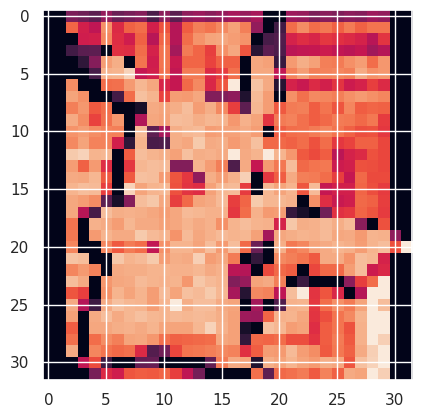

In [407]:
final_img = final_img.astype('int')
final_img = final_img.reshape((32,32))
print(final_img)
plt.imshow(final_img)

[[  0   0  40 ...  47   0   0]
 [  0   0  86 ...  90   0   0]
 [  0   0   0 ...  73   0   0]
 ...
 [  0   0 106 ... 127   0   0]
 [  0   0   0 ... 127   0   0]
 [  0   0   0 ... 118   0   0]]


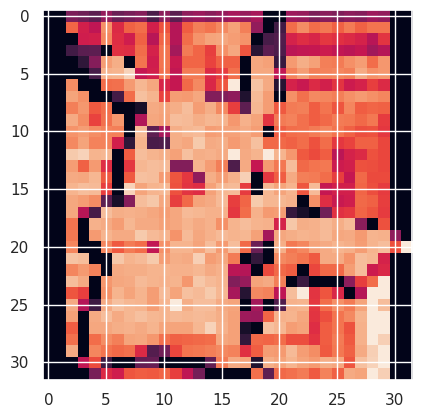

In [408]:
genimg = np.array(genimg).astype('int')
genimg = genimg.reshape((32,32))
print(genimg)
plt.imshow(genimg)

In [409]:
qml.specs(circuit)(pixel_values)

{'resources': Resources(num_wires=11, num_gates=6152, gate_types=defaultdict(<class 'int'>, {'Hadamard': 10, 'PauliX': 2046, 'MultiControlledX': 2048, 'RY': 2048}), depth=4098, shots=0),
 'gate_sizes': defaultdict(int, {1: 4104, 11: 2048}),
 'gate_types': defaultdict(int,
             {'Hadamard': 10,
              'PauliX': 2046,
              'MultiControlledX': 2048,
              'RY': 2048}),
 'num_operations': 6152,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 11,
 'num_trainable_params': 0,
 'depth': 4098,
 'num_device_wires': 11,
 'device_name': 'lightning.qubit',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'best',
 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift',
 'num_gradient_executions': 0}